In [1]:
a= "December special project"
b= "Satellite Image Processing"
c= "Prateek Dutta & Abhiroop Sarkar"
print("Introducing",a,"on",b,"created by",c)

Introducing December special project on Satellite Image Processing created by Prateek Dutta & Abhiroop Sarkar


In [2]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [3]:
ls

MyDrive/  Shareddrives/


In [4]:
cd/gdrive/MyDrive/Pollen grain classf/

/gdrive/.shortcut-targets-by-id/1NA7Mpa0zhAQooUk1tuLXKov9lXkYmVBU/Pollen grain classf


In [5]:
ls

 data/
'Pollen grain classification'/
 Project_pollen_grain_classification_inpynb.ipynb


In [6]:
cd/gdrive/MyDrive/Pollen grain classf/data/

/gdrive/.shortcut-targets-by-id/1NA7Mpa0zhAQooUk1tuLXKov9lXkYmVBU/Pollen grain classf/data


In [7]:
ls

 anadenanthera/   arecaceae/   arrabidaea/  'sequential-pollen grain.h5'


In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [9]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=40
CHANNELS=3

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Pollen grain classf/data/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 90 files belonging to 3 classes.


In [13]:
class_names = dataset.class_names
class_names

['anadenanthera', 'arecaceae', 'arrabidaea']

In [14]:
len(dataset)

2

In [15]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[175.       191.       214.      ]
  [175.       191.       214.      ]
  [174.74219  190.74219  213.74219 ]
  ...
  [175.       196.       215.      ]
  [175.       196.       215.      ]
  [175.       196.       215.      ]]

 [[175.       191.       214.      ]
  [175.       191.       214.      ]
  [174.88368  190.88368  213.88368 ]
  ...
  [175.       196.       215.      ]
  [175.       196.       215.      ]
  [175.       196.       215.      ]]

 [[175.24805  191.24805  214.24805 ]
  [175.11046  191.11046  214.11046 ]
  [175.       191.       214.      ]
  ...
  [175.       196.       215.      ]
  [175.       196.       215.      ]
  [175.       196.       215.      ]]

 ...

 [[108.73633  130.24023  128.48828 ]
  [107.62695  129.13086  127.37891 ]
  [106.2207   127.72461  125.97266 ]
  ...
  [105.48828  103.48828  107.99219 ]
  [105.59874  103.59874  108.102646]
  [105.73633  103.73633  108.240234]]

 [[104.29297  126.29297  124.29297 ]
  [103.1

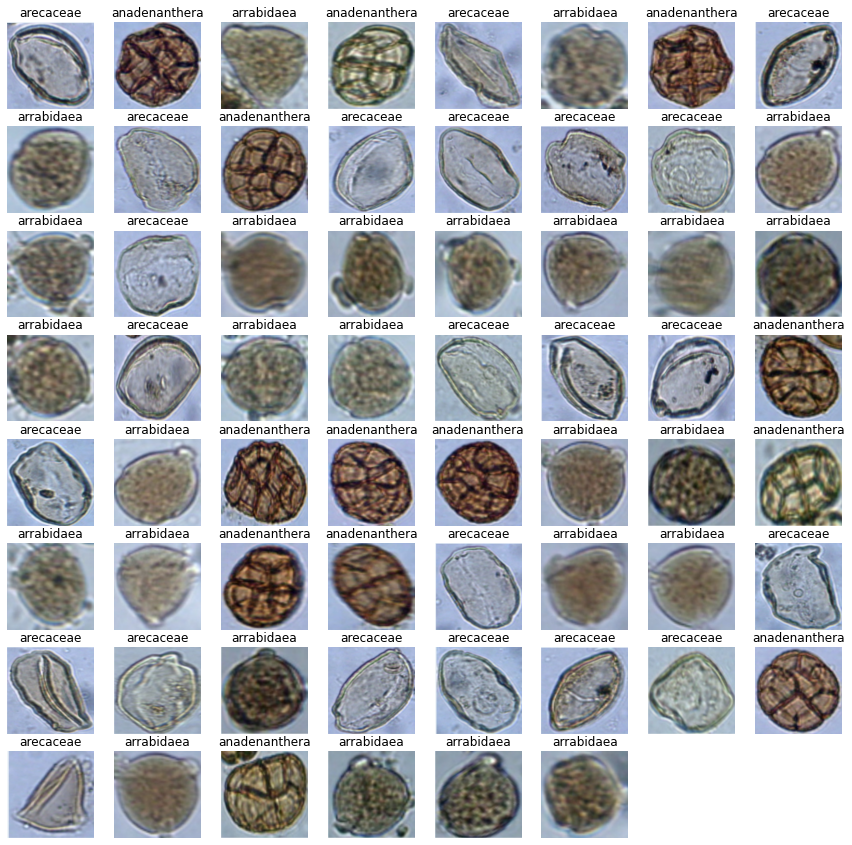

In [16]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
1/1 [==============================] - 5s 5s/step - loss: 2.1981 - accuracy: 0.0000e+00
Epoch 2/40
1/1 [==============================] - 3s 3s/step - loss: 2.1341 - accuracy: 0.5000
Epoch 3/40
1/1 [==============================] - 3s 3s/step - loss: 2.0085 - accuracy: 0.5000
Epoch 4/40
1/1 [==============================] - 3s 3s/step - loss: 1.7778 - accuracy: 0.5000
Epoch 5/40
1/1 [==============================] - 3s 3s/step - loss: 1.4591 - accuracy: 0.5000
Epoch 6/40
1/1 [==============================] - 3s 3s/step - loss: 1.3485 - accuracy: 0.5000
Epoch 7/40
1/1 [==============================] - 3s 3s/step - loss: 1.1934 - accuracy: 0.5000
Epoch 8/40
1/1 [==============================] - 3s 3s/step - loss: 1.0661 - accuracy: 0.5000
Epoch 9/40
1/1 [==============================] - 3s 3s/step - loss: 1.1397 - accuracy: 0.3571
Epoch 10/40
1/1 [==============================] - 3s 3s/step - loss: 1.0611 - accuracy: 0.3571
Epoch 11/40
1/1 [============================

In [25]:
model.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.3015 - accuracy: 0.9286


[0.3014678359031677, 0.9285714030265808]

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']

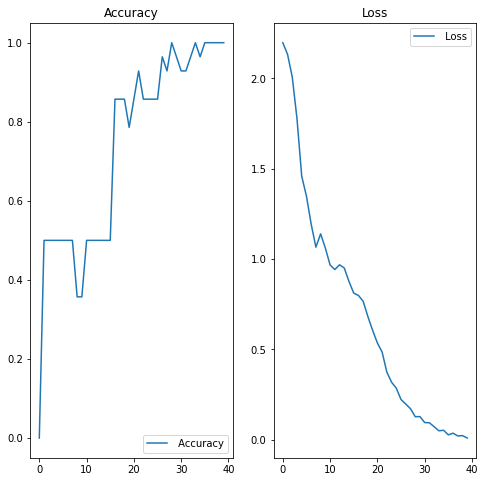

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

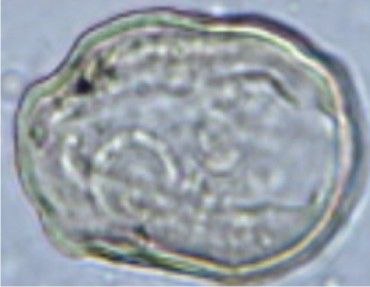

In [29]:
image_path = "/gdrive/My Drive/arecaceae_34.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [31]:
pred = model.predict(scaled_img)

In [32]:
output = class_names[np.argmax(pred)]

In [33]:
output

'arecaceae'

In [34]:
model.save("sequential-pollen grain.h5")